##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# {TF Probability、R、Stan} における線形混合効果回帰

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/HLM_TFP_R_Stan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/HLM_TFP_R_Stan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/HLM_TFP_R_Stan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/HLM_TFP_R_Stan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

## 1  はじめに

このコラボでは、線形混合効果回帰モデルを人気のあるトイデータセットに適合させます。R の `lme4`、Stan の混合効果パッケージ、および TensorFlow Probability (TFP) プリミティブを使用して、これを 3 回適合させます。そして、これらからほぼ同じ適合パラメータと事後分布を得られることを示します。

主な結論として、TFP には HLM のようなモデルを適合させるために必要な一般的な要素があり、`lme4` や `rstanarm` などの他のソフトウェアパッケージと一致する結果を生成します。このコラボは、比較したパッケージの計算効率を正確に反映したものではありません。

In [ ]:
%matplotlib inline

import os
from six.moves import urllib
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.core.pylabtools import figsize
figsize(11, 9)

import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

## 2  階層線形モデル


R、Stan、TFP を比較するために、[階層線形モデル](https://en.wikipedia.org/wiki/Multilevel_model) (HLM) を[ラドンデータセット](http://www.stat.columbia.edu/~gelman/arm/examples/radon/)に適合させます。このデータセットはゲルマンら (559 ページ、第 2 版、250 ページ、第 3 版) による[*ベイジアンデータ分析*](http://www.stat.columbia.edu/~gelman/book/)で有名になったものです。


次の生成モデルを前提としています。

$$\begin{align*} \text{for } &amp; c=1\ldots \text{NumCounties}:\ &amp; \beta_c \sim \text{Normal}\left(\text{loc}=0, \text{scale}=\sigma_C  \right) \ \text{for } &amp; i=1\ldots \text{NumSamples}:\ &amp;\eta_i = \underbrace{\omega_0 + \omega_1 \text{Floor}<em data-md-type="emphasis">i}</em>\text{fixed effects} + \underbrace{\beta_{ \text{County}<em data-md-type="emphasis">i} \log( \text{UraniumPPM}</em>{\text{County}<em data-md-type="emphasis">i}))}</em>\text{random effects} \ &amp;\log(\text{Radon}_i) \sim \text{Normal}(\text{loc}=\eta_i , \text{scale}=\sigma_N) \end{align*}$$


R の `lme4` 「チルダ表記」では、このモデルは次と同等です。

> `log_radon ~ 1 + floor +  (0 + log_uranium_ppm | county)`


${\beta_c}_{c=1}^\text{NumCounties}$ の事後分布 (証拠を条件とする) を使用して、$\omega, \sigma_C, \sigma_N$ の MLE を見つけます。

本質的に同じモデルですが、ランダム切片があります。*[付録 A](#scrollTo=tsXhZ4rtNUXL)* を参照してください。

HLM のより一般的な仕様については、*[付録 B](#scrollTo=H0w7ofFvNsxi)* を参照してください。

## 3  データマンジング

このセクションでは、[<code>radon</code> データセット](http://www.stat.columbia.edu/~gelman/arm/examples/radon/)を取得し、想定されるモデルに準拠するように最小限の前処理を行います。

In [ ]:
def load_and_preprocess_radon_dataset(state='MN'):
  """Preprocess Radon dataset as done in "Bayesian Data Analysis" book.
  
  We filter to Minnesota data (919 examples) and preprocess to obtain the
  following features:
  - `log_uranium_ppm`: Log of soil uranium measurements.
  - `county`: Name of county in which the measurement was taken.
  - `floor`: Floor of house (0 for basement, 1 for first floor) on which the
    measurement was taken.

  The target variable is `log_radon`, the log of the Radon measurement in the
  house.
  """
  ds = tfds.load('radon', split='train')
  radon_data = tfds.as_dataframe(ds)
  radon_data.rename(lambda s: s[9:] if s.startswith('feat') else s, axis=1, inplace=True)
  df = radon_data[radon_data.state==state.encode()].copy()

  # For any missing or invalid activity readings, we'll use a value of `0.1`.
  df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
  # Make county names look nice. 
  df['county'] = df.county.apply(lambda s: s.decode()).str.strip().str.title()
  # Remap categories to start from 0 and end at max(category).
  county_name = sorted(df.county.unique())
  df['county'] = df.county.astype(
      pd.api.types.CategoricalDtype(categories=county_name)).cat.codes
  county_name = list(map(str.strip, county_name))

  df['log_radon'] = df['radon'].apply(np.log)
  df['log_uranium_ppm'] = df['Uppm'].apply(np.log)
  df = df[['idnum', 'log_radon', 'floor', 'county', 'log_uranium_ppm']]

  return df, county_name

In [ ]:
radon, county_name = load_and_preprocess_radon_dataset()

In [ ]:
# We'll use the following directory to store our preprocessed dataset.
CACHE_DIR = os.path.join(os.sep, 'tmp', 'radon')

# Save processed data. (So we can later read it in R.)
if not tf.gfile.Exists(CACHE_DIR):
  tf.gfile.MakeDirs(CACHE_DIR)
with tf.gfile.Open(os.path.join(CACHE_DIR, 'radon.csv'), 'w') as f:
  radon.to_csv(f, index=False)

### 3.1  データを調査する

このセクションでは、提案されたモデルが合理的である理由を理解するために、`radon` データセットを調べます。

In [ ]:
radon.head()

log_radon  floor  county  log_uranium_ppm
0   0.788457      1       0        -0.689048
1   0.788457      0       0        -0.689048
2   1.064711      0       0        -0.689048
3   0.000000      0       0        -0.689048
4   1.131402      0       1        -0.847313

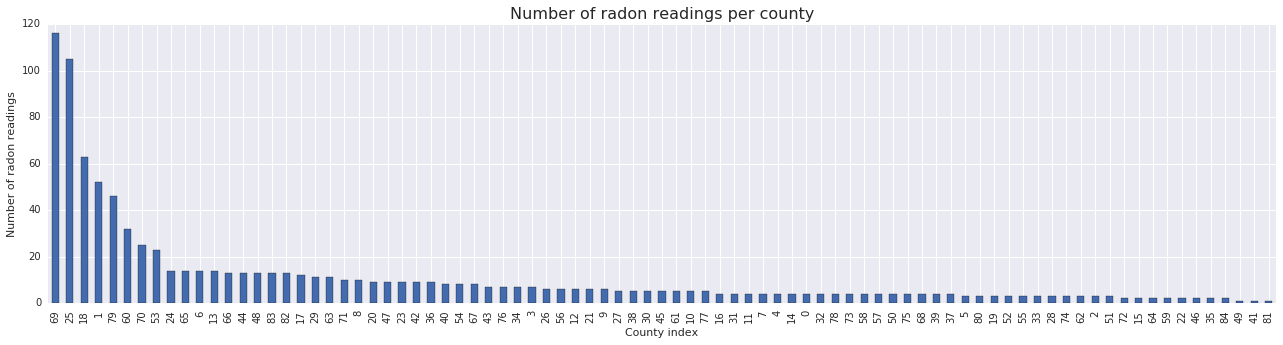

In [ ]:
fig, ax = plt.subplots(figsize=(22, 5));
county_freq = radon['county'].value_counts()
county_freq.plot(kind='bar', color='#436bad');
plt.xlabel('County index')
plt.ylabel('Number of radon readings')
plt.title('Number of radon readings per county', fontsize=16)
county_freq = np.array(zip(county_freq.index, county_freq.values))  # We'll use this later.

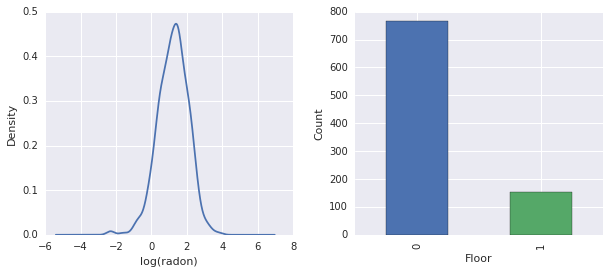

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=[10, 4]);

radon['log_radon'].plot(kind='density', ax=ax[0]);
ax[0].set_xlabel('log(radon)')

radon['floor'].value_counts().plot(kind='bar', ax=ax[1]);
ax[1].set_xlabel('Floor');
ax[1].set_ylabel('Count');

fig.subplots_adjust(wspace=0.25)

結論:

- 85 の郡のロングテールがあります (GLMM でよく発生します)。
- $\log(\text{Radon})$ には制約がありません (したがって、線形回帰は理にかなっているかもしれません)。
- 測定はほとんど $0$ 階で行われます。$1$ より上の階では測定は行われませんでした (したがって、固定効果には 2 つの重みしかありません)。


## 4  R を使用して HLM を適合させる

このセクションでは、R の [`lme4`](https://cran.r-project.org/web/packages/lme4/index.html) パッケージを使用して、上記の確率モデルを適合させます。

**注: このセクションを実行するには、R colab ランタイムに切り替える必要があります。**

In [ ]:
suppressMessages({
  library('bayesplot')
  library('data.table')
  library('dplyr')
  library('gfile')
  library('ggplot2')
  library('lattice')
  library('lme4')
  library('plyr')
  library('rstanarm')
  library('tidyverse')
  RequireInitGoogle()
})

In [ ]:
data = read_csv(gfile::GFile('/tmp/radon/radon.csv'))

Parsed with column specification:
cols(
  log_radon = col_double(),
  floor = col_integer(),
  county = col_integer(),
  log_uranium_ppm = col_double()
)


In [ ]:
head(data)

# A tibble: 6 x 4
  log_radon floor county log_uranium_ppm
      <dbl> <int>  <int>           <dbl>
1     0.788     1      0          -0.689
2     0.788     0      0          -0.689
3     1.06      0      0          -0.689
4     0         0      0          -0.689
5     1.13      0      1          -0.847
6     0.916     0      1          -0.847

In [ ]:
# https://github.com/stan-dev/example-models/wiki/ARM-Models-Sorted-by-Chapter
radon.model <- lmer(log_radon ~ 1 + floor  + (0 + log_uranium_ppm | county), data = data)

In [ ]:
summary(radon.model)

Linear mixed model fit by REML ['lmerMod']
Formula: log_radon ~ 1 + floor + (0 + log_uranium_ppm | county)
   Data: data

REML criterion at convergence: 2166.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5202 -0.6064  0.0107  0.6334  3.4111 

Random effects:
 Groups   Name            Variance Std.Dev.
 county   log_uranium_ppm 0.7545   0.8686  
 Residual                 0.5776   0.7600  
Number of obs: 919, groups:  county, 85

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.47585    0.03899   37.85
floor       -0.67974    0.06963   -9.76

Correlation of Fixed Effects:
      (Intr)
floor -0.330

$county


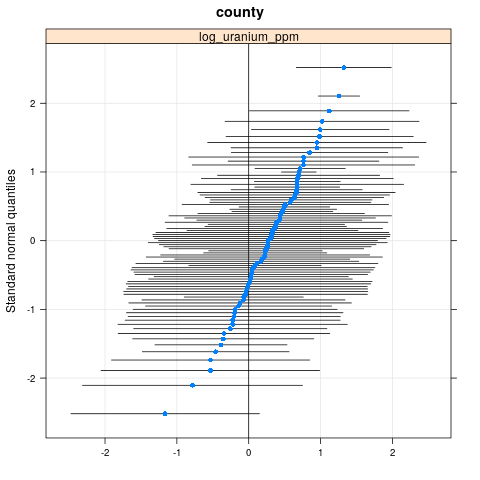

In [ ]:
qqmath(ranef(radon.model, condVar=TRUE))

In [ ]:
write.csv(as.data.frame(ranef(radon.model, condVar = TRUE)), '/tmp/radon/lme4_fit.csv')

## 5  Stan を使用して HLM を適合させる


このセクションでは、[rstanarm](http://mc-stan.org/users/interfaces/rstanarm) を使用して、上記の `lme4` モデルと同じ式/構文を使用して Stan モデルを適合させます。

`lme4` や以下の TF モデルとは異なり、`rstanarm` は完全なベイズモデルです。つまり、すべてのパラメータは正規分布から引き出され、パラメータ自体は分布から引き出されていると推定されます。

**注：このセクションを実行するには、`R` colab ランタイムに切り替える必要があります。**

In [ ]:
fit <- stan_lmer(log_radon ~ 1 + floor  + (0 + log_uranium_ppm | county), data = data)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1, Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1, Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1, Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1, Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1, Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1, Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1, Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1, Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1, Iteration: 2000 / 2000 [100%]  (Sampling)
 Elapsed Time: 7.73495 seconds (Warm-up)
               2.98852 seconds (Sampling)
               10.7235 seconds (Total)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 2).

Chain 2, Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 2, Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 2, Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 2, Iteration:  600 / 2000 

**注**: ランタイムは単一の CPU コアからのものです。(このコラボは、Stan または TFP ランタイムを忠実に表現することを目的としたものではありません。)

In [ ]:
fit

stan_lmer(formula = log_radon ~ 1 + floor + (0 + log_uranium_ppm | 
    county), data = data)

Estimates:
            Median MAD_SD
(Intercept)  1.5    0.0  
floor       -0.7    0.1  
sigma        0.8    0.0  

Error terms:
 Groups   Name            Std.Dev.
 county   log_uranium_ppm 0.87    
 Residual                 0.76    
Num. levels: county 85 

Sample avg. posterior predictive 
distribution of y (X = xbar):
         Median MAD_SD
mean_PPD 1.2    0.0   

Observations: 919  Number of unconstrained parameters: 90 

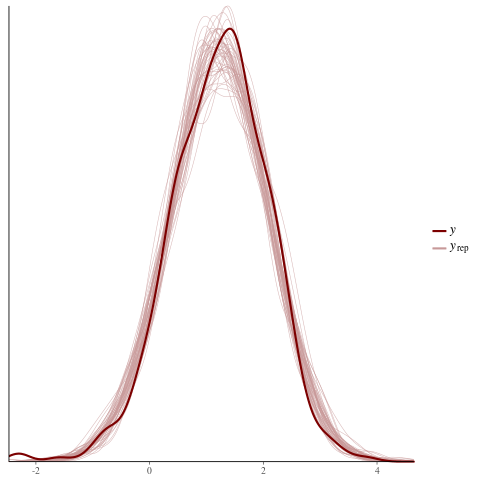

In [ ]:
color_scheme_set("red")
ppc_dens_overlay(y = fit$y,
                 yrep = posterior_predict(fit, draws = 50))

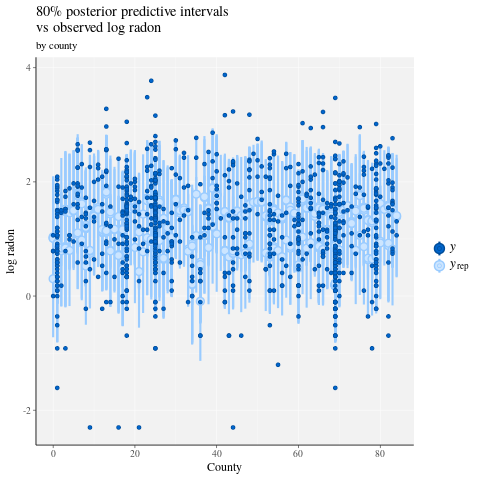

In [ ]:
color_scheme_set("brightblue")
ppc_intervals(
  y = data$log_radon,
  yrep = posterior_predict(fit),
  x = data$county,
  prob = 0.8
) +
  labs(
    x = "County",
    y = "log radon",
    title = "80% posterior predictive intervals \nvs observed log radon",
    subtitle = "by county"
  ) +
  panel_bg(fill = "gray95", color = NA) +
  grid_lines(color = "white")

In [ ]:
# Write the posterior samples (4000 for each variable) to a CSV.
write.csv(tidy(as.matrix(fit)), "/tmp/radon/stan_fit.csv")

**注: Python TF カーネルランタイムに切り替えます。**

In [ ]:
with tf.gfile.Open('/tmp/radon/lme4_fit.csv', 'r') as f:
  lme4_fit = pd.read_csv(f, index_col=0)

In [ ]:
lme4_fit.head()

grpvar             term  grp   condval    condsd
1  county  log_uranium_ppm    0  0.667653  0.465584
2  county  log_uranium_ppm    1  0.697805  0.123133
3  county  log_uranium_ppm    2 -0.010856  0.847489
4  county  log_uranium_ppm    3 -0.068872  0.422883
5  county  log_uranium_ppm    4  0.036075  0.825677

後で視覚化するために、lme4 からグループ変量効果の点推定と条件付き標準偏差を取得します。

In [ ]:
posterior_random_weights_lme4 = np.array(lme4_fit.condval, dtype=np.float32)
lme4_prior_scale = np.array(lme4_fit.condsd, dtype=np.float32)
print(posterior_random_weights_lme4.shape, lme4_prior_scale.shape)

(85,) (85,)


lme4 の推定平均と標準偏差を使用して、郡の重みのサンプルを抽出します。

In [ ]:
with tf.Session() as sess:
  lme4_dist = tfp.distributions.Independent(
      tfp.distributions.Normal(
          loc=posterior_random_weights_lme4,
          scale=lme4_prior_scale),
      reinterpreted_batch_ndims=1)
  posterior_random_weights_lme4_final_ = sess.run(lme4_dist.sample(4000))

In [ ]:
posterior_random_weights_lme4_final_.shape

(4000, 85)

また、Stan の適合から郡の重みの事後サンプルを取得します。

In [ ]:
with tf.gfile.Open('/tmp/radon/stan_fit.csv', 'r') as f:
  samples = pd.read_csv(f, index_col=0)

In [ ]:
samples.head()

X.Intercept.     floor  b.log_uranium_ppm.county.0.  \
1      1.450331 -0.757375                     1.093099   
2      1.453383 -0.659085                     0.560266   
3      1.460351 -0.804513                     1.145694   
4      1.438725 -0.565721                     0.204148   
5      1.457569 -0.658910                     0.140554   

   b.log_uranium_ppm.county.1.  b.log_uranium_ppm.county.2.  \
1                     0.603985                    -0.661680   
2                     0.580569                     0.419441   
3                     0.705337                     2.216364   
4                     0.810580                    -1.982466   
5                     0.593056                    -2.618940   

   b.log_uranium_ppm.county.3.  b.log_uranium_ppm.county.4.  \
1                    -0.667052                     0.549178   
2                    -0.154925                    -1.263534   
3                    -1.044031                     1.510397   
4                     1.044825                    -1.339406   
5                     0.484812                    -0.417834   

   b.log_uranium_ppm.county.5.  b.log_uranium_ppm.county.6.  \
1                    -0.150145                     1.486173   
2                     0.166291                     1.534917   
3                    -0.472675                     0.427448   
4                     0.643384                     2.379191   
5                     0.735558                     1.693997   

   b.log_uranium_ppm.county.7.    ...     b.log_uranium_ppm.county.76.  \
1                     0.053578    ...                         0.323107   
2                     1.141392    ...                         0.306941   
3                     0.940869    ...                         1.941637   
4                     0.295981    ...                        -0.832814   
5                     0.230496    ...                        -0.608215   

   b.log_uranium_ppm.county.77.  b.log_uranium_ppm.county.78.  \
1                      0.282121                     -0.188251   
2                      0.331696                      0.614852   
3                      0.188311                     -0.690044   
4                      0.246694                     -0.801078   
5                     -0.586245                      0.204547   

   b.log_uranium_ppm.county.79.  b.log_uranium_ppm.county.80.  \
1                      0.889385                      1.008348   
2                      0.153913                      1.253688   
3                      0.946370                      1.626093   
4                      0.072430                      0.108882   
5                      0.350195                      0.164781   

   b.log_uranium_ppm.county.81.  b.log_uranium_ppm.county.82.  \
1                      0.429430                      0.404690   
2                      0.246746                      0.849947   
3                      0.930756                      0.141125   
4                     -0.203805                      0.443365   
5                     -0.009945                      0.023533   

   b.log_uranium_ppm.county.83.  b.log_uranium_ppm.county.84.     sigma  
1                      0.112424                     -0.071612  0.778706  
2                     -1.399027                     -1.697360  0.754960  
3                      0.041392                     -0.135538  0.763605  
4                     -0.901578                     -0.063022  0.750404  
5                     -0.177017                     -0.425871  0.755898  

[5 rows x 88 columns]

In [ ]:
posterior_random_weights_cols = [
    col for col in samples.columns if 'b.log_uranium_ppm.county' in col
]
posterior_random_weights_final_stan = samples[
    posterior_random_weights_cols].values
print(posterior_random_weights_final_stan.shape)

(4000, 85)


[この Stan の例](https://github.com/stan-dev/example-models/blob/master/ARM/Ch.16/radon.3.stan)は、確率モデルを直接指定することにより、TFP に似たスタイルで LMER を実装する方法を示しています。

## 6  TF Probability を使用して HLM を適合させる

このセクションでは、低レベルの TensorFlow Probability プリミティブ (`Distributions`) を使用して、階層線形モデルを指定し、不明なパラメータを適合させます。

In [ ]:
# Handy snippet to reset the global graph and global session.
with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  tf.reset_default_graph()
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession()

### 6.1  モデルの指定

このセクションでは、TFP プリミティブを使用して[ラドン線形混合効果モデル](#scrollTo=IFC9r-h0XlQ3)を指定します。これを行うには、2 つの TFP 分布を生成する 2 つの関数を指定します。

- `make_weights_prior`: ランダムな重みの多変量正規分布 (線形予測子を計算するために $\log(\text{UraniumPPM}_{c_i})$ を掛けます)。
- `make_log_radon_likelihood`: 観測された各 $\log(\text{Radon}_i)$ 従属変数にわたる `Normal` 分布のバッチ。


これらの各分布のパラメータを適合するため、TF 変数 ([`tf.get_variable`](https://www.tensorflow.org/api_docs/python/tf/get_variable)) を使用する必要があります。ただし、制約なしの最適化を使用したいので、必要なセマンティクスを実現するために実数値を制約する方法を見つける必要があります (例: 標準偏差を表す正の値)。 

In [ ]:
inv_scale_transform = lambda y: np.log(y)  # Not using TF here.
fwd_scale_transform = tf.exp

次の関数は、事前 の$p(\beta|\sigma_C)$ を作成します。ここで、$\beta$ は変量効果の重みを示し、$\sigma_C$ は標準偏差を示します。

`tf.make_template` を使用して、この関数の最初の呼び出しで使用する TF 変数がインスタンス化され、その後のすべての呼び出しで *reuse* 変数の最新の値がインスタンス化されるようにします。

In [ ]:
def _make_weights_prior(num_counties, dtype):
  """Returns a `len(log_uranium_ppm)` batch of univariate Normal."""
  raw_prior_scale = tf.get_variable(
      name='raw_prior_scale',
      initializer=np.array(inv_scale_transform(1.), dtype=dtype))
  return tfp.distributions.Independent(
      tfp.distributions.Normal(
          loc=tf.zeros(num_counties, dtype=dtype),
          scale=fwd_scale_transform(raw_prior_scale)),
      reinterpreted_batch_ndims=1)


make_weights_prior = tf.make_template(
    name_='make_weights_prior', func_=_make_weights_prior)

次の関数は、尤度 $p(y|x,\omega,\beta,\sigma_N)$ を作成します。ここで、$y,x$ は応答と証拠を示し、$\omega,\beta$ は固定効果と変量効果の重みを示し、$\sigma_N$ は標準偏差を示します。

ここでも、`tf.make_template` を使用して、TF 変数が呼び出し間で再利用されるようにします。

In [ ]:
def _make_log_radon_likelihood(random_effect_weights, floor, county,
                               log_county_uranium_ppm, init_log_radon_stddev):
  raw_likelihood_scale = tf.get_variable(
      name='raw_likelihood_scale',
      initializer=np.array(
          inv_scale_transform(init_log_radon_stddev), dtype=dtype))
  fixed_effect_weights = tf.get_variable(
      name='fixed_effect_weights', initializer=np.array([0., 1.], dtype=dtype))
  fixed_effects = fixed_effect_weights[0] + fixed_effect_weights[1] * floor
  random_effects = tf.gather(
      random_effect_weights * log_county_uranium_ppm,
      indices=tf.to_int32(county),
      axis=-1)
  linear_predictor = fixed_effects + random_effects
  return tfp.distributions.Normal(
      loc=linear_predictor, scale=fwd_scale_transform(raw_likelihood_scale))


make_log_radon_likelihood = tf.make_template(
    name_='make_log_radon_likelihood', func_=_make_log_radon_likelihood)

最後に、事前と尤度生成器を使用して、同時対数密度を構築します。

In [ ]:
def joint_log_prob(random_effect_weights, log_radon, floor, county,
                   log_county_uranium_ppm, dtype):
  num_counties = len(log_county_uranium_ppm)
  rv_weights = make_weights_prior(num_counties, dtype)
  rv_radon = make_log_radon_likelihood(
      random_effect_weights,
      floor,
      county,
      log_county_uranium_ppm,
      init_log_radon_stddev=radon.log_radon.values.std())
  return (rv_weights.log_prob(random_effect_weights)
          + tf.reduce_sum(rv_radon.log_prob(log_radon), axis=-1))

### 6.2 トレーニング (期待値最大化の確率的近似)

線形混合効果回帰モデルを適合させるために、期待値最大化アルゴリズム (SAEM) の確率的近似バージョンを使用します。基本的な考え方は、事後のサンプルを使用して、予想される同時対数密度 (E ステップ) を概算することです。次に、この計算を最大化するパラメータを見つけます (M ステップ)。具体的には、不動点イテレーションは次の式で取得できます。

ここで、$x$ は証拠、$Z$ は無視する必要のある潜在変数、および $\theta,\theta_0$ の可能なパラメータ化を示します。

詳細については、次を参照してください。[*Convergence of a stochastic approximation version of the EM algorithms* by Bernard Delyon, Marc Lavielle, Eric, Moulines (Ann. Statist., 1999)](https://projecteuclid.org/euclid.aos/1018031103)。

詳細については、次を参照してください。[*Convergence of a stochastic approximation version of the EM algorithms* by Bernard Delyon, Marc Lavielle, Eric, Moulines (Ann. Statist., 1999)](https://projecteuclid.org/euclid.aos/1018031103)。

E ステップを計算するには、事後からサンプリングする必要があります。事後分布からサンプリングをすのは簡単ではないため、ハミルトニアンモンテカルロ (HMC) を使用します。HMC は、非正規化された事後対数密度の勾配 (パラメータではなく、wrt 状態) を使用して新しいサンプルを提供するマルコフ連鎖モンテカルロ法の手順です。


正規化されていない事後対数密度を指定するのは簡単です。これは、条件付けする「固定」された同時対数密度にすぎません。

In [ ]:
# Specify unnormalized posterior.

dtype = np.float32

log_county_uranium_ppm = radon[
    ['county', 'log_uranium_ppm']].drop_duplicates().values[:, 1]
log_county_uranium_ppm = log_county_uranium_ppm.astype(dtype)

def unnormalized_posterior_log_prob(random_effect_weights):
  return joint_log_prob(
      random_effect_weights=random_effect_weights,
      log_radon=dtype(radon.log_radon.values),
      floor=dtype(radon.floor.values),
      county=np.int32(radon.county.values),
      log_county_uranium_ppm=log_county_uranium_ppm,
      dtype=dtype)

これで、HMC 遷移カーネルを作成して E ステップのセットアップを完了しました。

注意:

- `state_stop_gradient=True`を使用して、M ステップが  MCMC からの抽出を介してバックプロパゲーションするのを防ぎます。(E ステップでは*前*の最もよく知られている推定量で意図的にパラメータ化されているため、バックプロパゲーションを行う必要はありません。)

- [`tf.placeholder`](https://www.tensorflow.org/api_docs/python/tf/placeholder) を使用して、最終的に TF グラフを実行するときに、前のイテレーションのランダム MCMC サンプルを次のイテレーションのチェーンの値としてフィードできるようにします。

- TFP の適応型 `step_size` ヒューリスティック、`tfp.mcmc.hmc_step_size_update_fn` を使用します。

In [ ]:
# Set-up E-step.

step_size = tf.get_variable(
    'step_size',
    initializer=np.array(0.2, dtype=dtype),
    trainable=False)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_posterior_log_prob,
    num_leapfrog_steps=2,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=None),
    state_gradients_are_stopped=True)

init_random_weights = tf.placeholder(dtype, shape=[len(log_county_uranium_ppm)])

posterior_random_weights, kernel_results = tfp.mcmc.sample_chain(
    num_results=3,
    num_burnin_steps=0,
    num_steps_between_results=0,
    current_state=init_random_weights,
    kernel=hmc)

ここで、M ステップを設定します。これは基本的に、TF で行うことのある最適化と同じです。

In [ ]:
# Set-up M-step.

loss = -tf.reduce_mean(kernel_results.accepted_results.target_log_prob)

global_step = tf.train.get_or_create_global_step()

learning_rate = tf.train.exponential_decay(
    learning_rate=0.1,
    global_step=global_step,
    decay_steps=2,
    decay_rate=0.99)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

最後に、いくつかのハウスキーピングタスクを実行します。すべての変数が初期化されていることを TF に通知する必要があります。また、TF 変数へのハンドルを作成して、プロシージャの各イテレーションでそれらの値を `print` できるようにします。 

In [ ]:
# Initialize all variables.

init_op = tf.initialize_all_variables()

In [ ]:
# Grab variable handles for diagnostic purposes.

with tf.variable_scope('make_weights_prior', reuse=True):
  prior_scale = fwd_scale_transform(tf.get_variable(
      name='raw_prior_scale', dtype=dtype))
  
with tf.variable_scope('make_log_radon_likelihood', reuse=True):
  likelihood_scale = fwd_scale_transform(tf.get_variable(
      name='raw_likelihood_scale', dtype=dtype))
  fixed_effect_weights = tf.get_variable(
      name='fixed_effect_weights', dtype=dtype)

### 6.3  実行

このセクションでは、SAEM TF グラフを実行します。ここで重要な点は、HMC カーネルからの最後のものを次のイテレーションにフィードすることです。これは、`feed_dict` 呼び出しで `sess.run` を使用することで実現されます。

In [ ]:
init_op.run()
w_ = np.zeros([len(log_county_uranium_ppm)], dtype=dtype)

In [ ]:
%%time
maxiter = int(1500)
num_accepted = 0
num_drawn = 0
for i in range(maxiter):
  [
      _,
      global_step_,
      loss_,
      posterior_random_weights_,
      kernel_results_,
      step_size_,
      prior_scale_,
      likelihood_scale_,
      fixed_effect_weights_,
  ] = sess.run([
      train_op,
      global_step,
      loss,
      posterior_random_weights,
      kernel_results,
      step_size,
      prior_scale,
      likelihood_scale,
      fixed_effect_weights,
  ], feed_dict={init_random_weights: w_})
  w_ = posterior_random_weights_[-1, :]
  num_accepted += kernel_results_.is_accepted.sum()
  num_drawn += kernel_results_.is_accepted.size
  acceptance_rate = num_accepted / num_drawn
  if i % 100 == 0 or i == maxiter - 1:
    print('global_step:{:>4}  loss:{: 9.3f}  acceptance:{:.4f}  '
          'step_size:{:.4f}  prior_scale:{:.4f}  likelihood_scale:{:.4f}  '
          'fixed_effect_weights:{}'.format(
              global_step_, loss_.mean(), acceptance_rate, step_size_,
              prior_scale_, likelihood_scale_, fixed_effect_weights_))              

global_step:   0  loss: 1966.948  acceptance:1.0000  step_size:0.2000  prior_scale:1.0000  likelihood_scale:0.8529  fixed_effect_weights:[ 0.  1.]
global_step: 100  loss: 1165.385  acceptance:0.6205  step_size:0.2040  prior_scale:0.9568  likelihood_scale:0.7611  fixed_effect_weights:[ 1.47523439 -0.66043079]
global_step: 200  loss: 1149.851  acceptance:0.6766  step_size:0.2081  prior_scale:0.7465  likelihood_scale:0.7665  fixed_effect_weights:[ 1.48918796 -0.67058587]
global_step: 300  loss: 1163.464  acceptance:0.6811  step_size:0.2040  prior_scale:0.8445  likelihood_scale:0.7594  fixed_effect_weights:[ 1.46291411 -0.67586178]
global_step: 400  loss: 1158.846  acceptance:0.6808  step_size:0.2081  prior_scale:0.8377  likelihood_scale:0.7574  fixed_effect_weights:[ 1.47349834 -0.68823022]
global_step: 500  loss: 1154.193  acceptance:0.6766  step_size:0.1961  prior_scale:0.8546  likelihood_scale:0.7564  fixed_effect_weights:[ 1.47703862 -0.67521363]
global_step: 600  loss: 1163.903  acce

約 1500 ステップ後、パラメータの推定値は安定しました。

### 6.4  結果

パラメータを適合させたので、多数の事後サンプルを生成して結果を調べてみます。

In [ ]:
%%time
posterior_random_weights_final, kernel_results_final = tfp.mcmc.sample_chain(
    num_results=int(15e3),
    num_burnin_steps=int(1e3),
    current_state=init_random_weights,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=unnormalized_posterior_log_prob,
      num_leapfrog_steps=2,
      step_size=step_size))

[
    posterior_random_weights_final_,
    kernel_results_final_,
] = sess.run([
    posterior_random_weights_final,
    kernel_results_final,
], feed_dict={init_random_weights: w_})

CPU times: user 1min 42s, sys: 26.6 s, total: 2min 8s
Wall time: 35.1 s


In [ ]:
print('prior_scale: ', prior_scale_)
print('likelihood_scale: ', likelihood_scale_)
print('fixed_effect_weights: ', fixed_effect_weights_)
print('acceptance rate final: ', kernel_results_final_.is_accepted.mean())

prior_scale:  0.873799
likelihood_scale:  0.758913
fixed_effect_weights:  [ 1.47624075 -0.67875224]
acceptance rate final:  0.7448


次に、$\beta_c \log(\text{UraniumPPM}_c)$ 変量効果の箱ひげ図を作成します。郡の頻度を減らして、変量効果を並べ替えます。

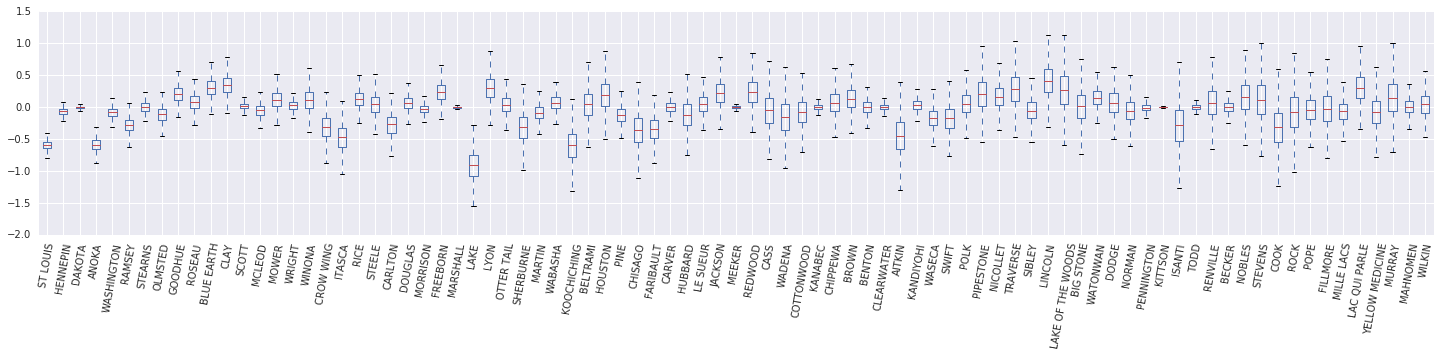

In [ ]:
x = posterior_random_weights_final_ * log_county_uranium_ppm
I = county_freq[:, 0]
x = x[:, I]
cols = np.array(county_name)[I]
pw = pd.DataFrame(x)
pw.columns = cols

fig, ax = plt.subplots(figsize=(25, 4))
ax = pw.boxplot(rot=80, vert=True);

この箱ひげ図から、郡レベルの $\log(\text{UraniumPPM})$ 変量効果の分散は、データセットにある郡のデータが少ない場合に増加することがわかります。直感的には、これは理にかなっています。証拠が少ない場合は、特定の郡の影響について確信が持てません。

## 7 並べて比較する

次に、3 つの手順すべての結果を比較します。これを行うために、Stan と TFP によって生成された事後サンプルの非パラメータ推定値を計算します。また、R の `lme4` パッケージによって生成されたパラメトリック (概算) 推定値と比較します。

次のプロットは、ミネソタ州の各郡の各重みの事後分布を示しています。Stan (赤)、TFP (青)、および R の`lme4` (オレンジ) の結果を示します。Stan と TFP の結果をシェーディングするため、2つ が一致すると紫色になると予想されます。簡単にするために、R からの結果はシェーディングしません。各サブプロットは単一の郡を表し、ラスタースキャンの順序で頻度の降順で並べられます (つまり、左から右、次に上から下)。

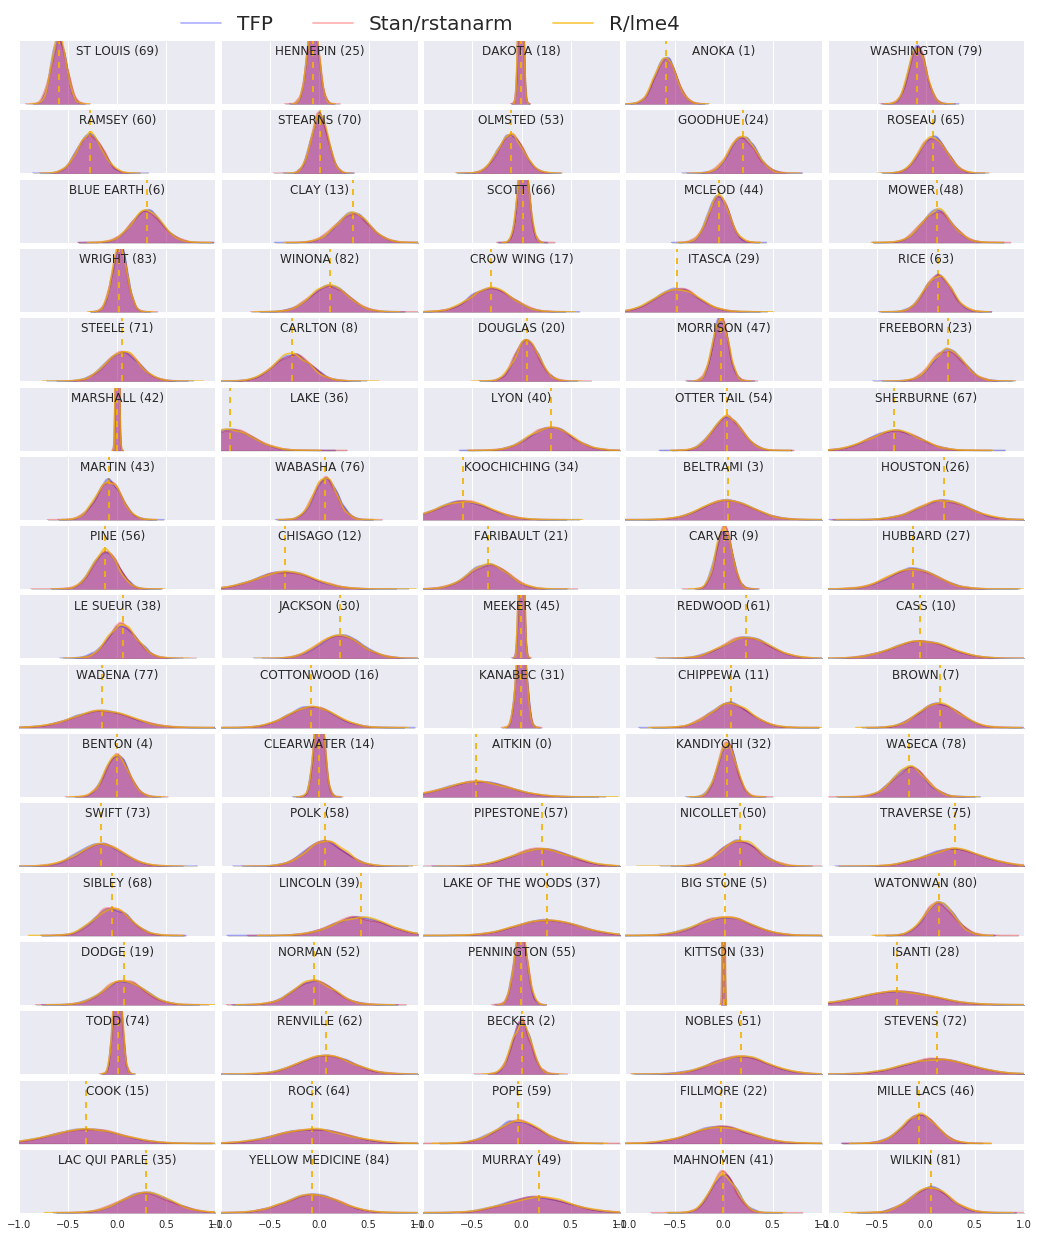

In [ ]:
nrows = 17
ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(18, 21), sharey=True, sharex=True)
with warnings.catch_warnings():
  warnings.simplefilter('ignore')
  ii = -1
  for r in range(nrows):
    for c in range(ncols):
      ii += 1
      idx = county_freq[ii, 0]
      sns.kdeplot(
          posterior_random_weights_final_[:, idx] * log_county_uranium_ppm[idx],
          color='blue',
          alpha=.3,
          shade=True,
          label='TFP',
          ax=ax[r][c])
      sns.kdeplot(
          posterior_random_weights_final_stan[:, idx] *
          log_county_uranium_ppm[idx],
          color='red',
          alpha=.3,
          shade=True,
          label='Stan/rstanarm',
          ax=ax[r][c])
      sns.kdeplot(
          posterior_random_weights_lme4_final_[:, idx] *
          log_county_uranium_ppm[idx],
          color='#F4B400',
          alpha=.7,
          shade=False,
          label='R/lme4',
          ax=ax[r][c])
      ax[r][c].vlines(
          posterior_random_weights_lme4[idx] * log_county_uranium_ppm[idx],
          0,
          5,
          color='#F4B400',
          linestyle='--')
      ax[r][c].set_title(county_name[idx] + ' ({})'.format(idx), y=.7)
      ax[r][c].set_ylim(0, 5)
      ax[r][c].set_xlim(-1., 1.)
      ax[r][c].get_yaxis().set_visible(False)
      if ii == 2:
        ax[r][c].legend(bbox_to_anchor=(1.4, 1.7), fontsize=20, ncol=3)
      else:
        ax[r][c].legend_.remove()
  fig.subplots_adjust(wspace=0.03, hspace=0.1)

## 8  結論

このコラボでは、線形混合効果回帰モデルをラドンデータセットに適合させました。R、Stan、TensorFlow Probability の 3 つの異なるソフトウェアパッケージを試し、3 つの異なるソフトウェアパッケージによって計算された 85 の事後分布をプロットしました。 

## 付録 A：代替のラドン HLM (ランダム切片の追加)

このセクションでは、各郡に関連付けられたランダム切片も持つ代替 HLM について説明します。

$$\begin{align*} \text{for } &amp; c=1\ldots \text{NumCounties}:\ &amp; \beta_c \sim \text{MultivariateNormal}\left(\text{loc}=\left[ \begin{array}{c} 0 \ 0 \end{array}\right] , \text{scale}=\left[\begin{array}{cc} \sigma_{11}  &amp; 0 \ \sigma_{12} &amp; \sigma_{22} \end{array}\right] \right) \ \text{for } &amp; i=1\ldots \text{NumSamples}:\ &amp; c_i := \text{County}<em data-md-type="emphasis">i \ &amp;\eta_i = \underbrace{\omega_0 + \omega_1\text{Floor}<em data-md-type="emphasis">i \vphantom{\log( \text{CountyUraniumPPM}</em>{c_i}))}}</em>{\text{fixed effects}}  + \underbrace{\beta_{c_i,0} + \beta_{c_i,1}\log( \text{CountyUraniumPPM}<em data-md-type="emphasis">{c_i}))}</em>{\text{random effects}} \ &amp;\log(\text{Radon}_i) \sim \text{Normal}(\text{loc}=\eta_i , \text{scale}=\sigma) \end{align*}$$


R の `lme4` 「チルダ表記」では、このモデルは次と同等です。

> `log_radon ~ 1 + floor + (1 + log_county_uranium_ppm | county)`

## 付録 B: 一般化線形混合効果モデル

このセクションでは、本文で使用されているものよりも、階層線形モデルのより一般的な特性を示します。このより一般的なモデルは、[一般化線形混合効果モデル](https://en.wikipedia.org/wiki/Generalized_linear_mixed_model) (GLMM) として知られています。


GLMM は、[一般化線形モデル](https://en.wikipedia.org/wiki/Generalized_linear_model) (GLM) を一般化したものです。GLMM は、サンプル固有のランダムノイズを予測線形応答に組み込むことにより、GLM を拡張します。これは、まれな特徴がより一般的な特徴と情報を共有できるため、便利なこともあります。


生成プロセスとして、一般化線形混合効果モデル (GLMM) には次の特徴があります。

\begin{align} \text{for } &amp; r = 1\ldots R:  \hspace{2.45cm}\text{# for each random-effect group}\ &amp;\begin{aligned} \text{for } &amp;c = 1\ldots |C_r|:  \hspace{1.3cm}\text{# for each category ("level") of group $r$}\ &amp;\begin{aligned} \beta_{rc} &amp;\sim \text{MultivariateNormal}(\text{loc}=0_{D_r}, \text{scale}=\Sigma_r^{1/2}) \end{aligned} \end{aligned}\ \text{for } &amp; i = 1 \ldots N:  \hspace{2.45cm}\text{# for each sample}\ &amp;\begin{aligned} &amp;\eta_i = \underbrace{\vphantom{\sum_{r=1}^R}x_i^\top\omega}*\text{fixed effects} + \underbrace{\sum*{r=1}^R z_{r,i}^\top \beta_{r,C_r(i) }}*\text{random effects} \ &amp;Y_i|x_i,\omega,{z*{r,i} , \beta_r}_{r=1}^R \sim \text{Distribution}(\text{mean}= g^{-1}(\eta_i)) \end{aligned} \end{align}


ここでは、

\begin{align} R &amp;= \text{number of random-effect groups}\ |C_r| &amp;= \text{number of categories for group $r$}\ N &amp;= \text{number of training samples}\ x_i,\omega &amp;\in \mathbb{R}^{D_0}\ D_0 &amp;= \text{number of fixed-effects}\ C_r(i) &amp;= \text{category (under group $r$) of the $i$th sample}\ z_{r,i} &amp;\in \mathbb{R}^{D_r}\ D_r &amp;= \text{number of random-effects associated with group $r$}\ \Sigma_{r} &amp;\in {S\in\mathbb{R}^{D_r \times D_r} : S \succ 0 }\ \eta_i\mapsto g^{-1}(\eta_i) &amp;= \mu_i, \text{inverse link function}\ \text{Distribution} &amp;=\text{some distribution parameterizable solely by its mean} \end{align}


つまり、これは、各グループのすべてのカテゴリが iid MVN、$\beta_{rc}$ に関連付けられていることを意味します。$\beta_{rc}$ の抽出は常に独立していますが、グループ $r$ に対してのみ同じように分散されます。$r\in{1,\ldots,R}$ ごとに 1 つの $\Sigma_r$ があることに注意してください。

サンプルのグループの特徴である $z_{r,i}$ と密接に組み合わせると、結果は $i$ 番目の予測線形応答 (それ以外の場合は $x_i^\top\omega$) のサンプル固有のノイズになります。


${\Sigma_r:r\in{1,\ldots,R}}$ を推定する場合、基本的に、変量効果グループがもつノイズの量を推定します。そうしないと、 $x_i^\top\omega$ に存在する信号が失われます。

$\text{Distribution}$ および[逆リンク関数](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function) $g^{-1}$ にはさまざまなオプションがあります。一般的なオプションは次のとおりです。

- $Y_i\sim\text{Normal}(\text{mean}=\eta_i, \text{scale}=\sigma)$,
- $Y_i\sim\text{Binomial}(\text{mean}=n_i \cdot \text{sigmoid}(\eta_i), \text{total_count}=n_i)$
- $Y_i\sim\text{Poisson}(\text{mean}=\exp(\eta_i))$

その他のオプションについては、[`tfp.glm`](https://github.com/tensorflow/probability/tree/main/tensorflow_probability/python/glm) モジュールを参照してください。